In [1]:
PROJECT_NAME = "reverse-gene-finder"

In [2]:
import os
PROJECT_HOME = os.path.join("/content/drive/My Drive/Projects", PROJECT_NAME)

import sys
sys.path.append(PROJECT_HOME)

In [3]:
# Google Drive storage setup
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
import pickle
import warnings

import numpy as np
import pandas as pd

from collections import defaultdict
from matplotlib import pyplot as plt

In [5]:
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [6]:
# Load gene token dictionary

token_dictionary_file = os.path.join(PROJECT_HOME, "libs", "token_dictionary.pkl")
with open(token_dictionary_file, "rb") as f:
    gene_token_dict = pickle.load(f)

token_gene_dict = {v: k for k, v in gene_token_dict.items()}
pad_token_id = gene_token_dict.get("<pad>")

In [7]:
# Load gene information

gene_info = pd.read_csv(os.path.join(PROJECT_HOME, "data", "gene_info.csv"))

gene_id_to_name = {}
gene_name_to_id = {}
for idx, row in gene_info.iterrows():
    gene_id_to_name[row['gene_id']] = row['gene_name']
    gene_name_to_id[row['gene_name']] = row['gene_id']

In [8]:
# Load causal tracing results

indirect_effects = np.load(os.path.join(PROJECT_HOME, "results", "indirect_effects.npy"))
attention_weights = np.load(os.path.join(PROJECT_HOME, "results", "attention_weights.npy"))
input_ids = np.load(os.path.join(PROJECT_HOME, "results", "input_ids.npy"))

sample_size = indirect_effects.shape[0]
input_length = indirect_effects.shape[1]
num_layers = indirect_effects.shape[2]

In [9]:
# Identify the most causal neurons

top_percentile = 5
cutoff_value = np.quantile(indirect_effects.ravel(), 1-top_percentile/100)

most_causal_neurons_list = []
for sample in range(sample_size):
    indirect_effects_per_sample = indirect_effects[sample]
    # keep the most causal neurons only
    indirect_effects_per_sample[indirect_effects_per_sample < cutoff_value] = 0
    most_causal_neurons_list.append(indirect_effects_per_sample)

most_causal_neurons = np.stack(most_causal_neurons_list)

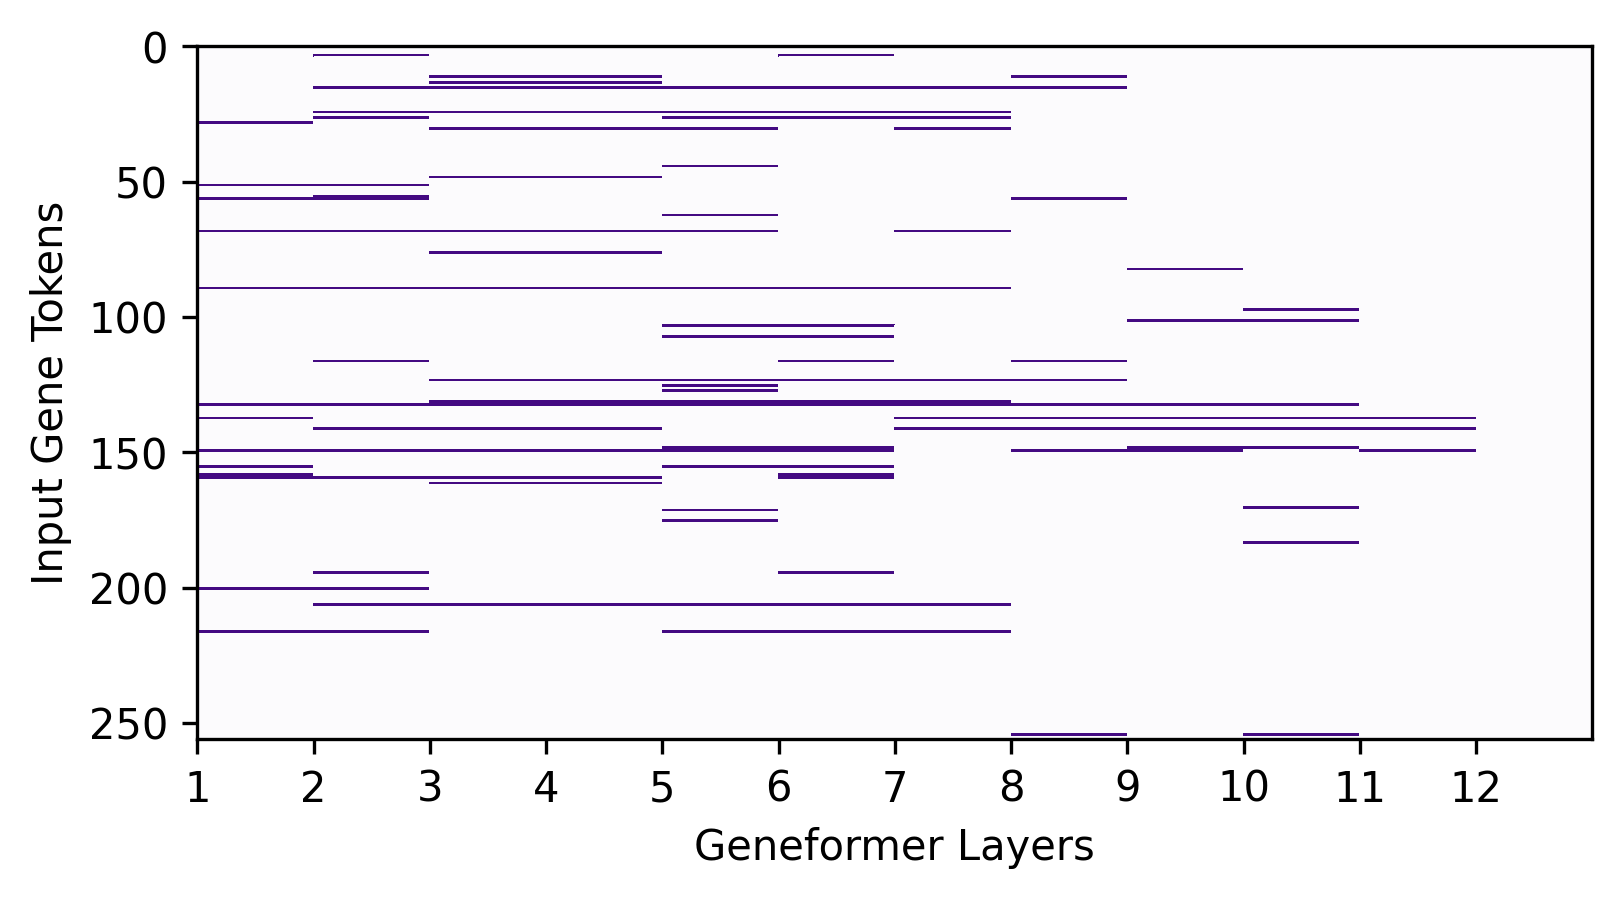

In [10]:
# Visualizaton for the most causal neurons

average_most_causal_neurons = np.mean(indirect_effects, axis=0)
cutoff_value = np.quantile(average_most_causal_neurons.ravel(), 1-top_percentile/100)
average_most_causal_neurons[average_most_causal_neurons < cutoff_value] = 0

fig, ax = plt.subplots(figsize=(6, 3), dpi=300)
h = ax.pcolor(
    average_most_causal_neurons,
    cmap="Purples",
    vmin=0,
)

ax.set_xticks(list(range(0, num_layers)))
ax.set_xticklabels(list(range(1, num_layers+1)))
ax.set_xlabel("Geneformer Layers")
ax.set_ylabel("Input Gene Tokens")
ax.invert_yaxis()

plt.show()

In [11]:
# Backtracking to gene tokens

gene_token_scores = defaultdict(list)

for sample in range(sample_size):
    # initilize the input token scores at the last layer as zeros
    input_token_score = np.zeros(input_length)
    # backtracking from the last layer num_layers-1 to the first layer 0
    for layer in range(num_layers-1, -1, -1):
        input_token_score = np.matmul(attention_weights[sample, layer-1, :, :], (input_token_score + most_causal_neurons[sample, :, layer]))
    for i in range(input_length):
        gene_token_id = int(input_ids[sample, i])
        token_score = float(input_token_score[i])
        gene_token_scores[gene_token_id].append(token_score)

In [12]:
# Identify the most causal gene tokens and genes

gene_score_dict = {}
for gene_token_id in gene_token_scores:
    gene_score_dict[gene_token_id] = np.sum(gene_token_scores[gene_token_id]) / sample_size

TOP_N_GENES = 10
print('Top %d genes:' % TOP_N_GENES)
top_genes = []
for idx, gene_token_id in enumerate(sorted(gene_score_dict, key=gene_score_dict.get, reverse=True)):
    score = gene_score_dict[gene_token_id]
    gene_id = token_gene_dict.get(gene_token_id)
    gene_name = gene_id_to_name[gene_id]
    if idx < TOP_N_GENES:
        top_genes.append(gene_name)
        print("%s (%.3f)" % (gene_name, score))

Top 10 genes:
PLXDC2 (0.499)
MT-CO3 (0.498)
DOCK4 (0.482)
ARHGAP24 (0.450)
MEF2A (0.428)
RUNX1 (0.427)
ITPR2 (0.426)
FOXN3 (0.406)
MT-CO1 (0.392)
SORL1 (0.389)


In [13]:
# Pathways for the selected genes

import requests
from io import StringIO

# https://string-db.org/help/api/
base_url = "https://version-11-0.string-db.org"
request_url = '%s/api/tsv/enrichment' % base_url

params = {
    "identifiers" : "%0d".join(top_genes),
    "species" : 9606, # Human
    'caller_identity': 'gene_enrichment_analysis'
}

response = requests.post(request_url, data=params)
data = response.text
tsv_data = StringIO(data)
for idx, line in enumerate(tsv_data):
    if idx == 0:
        # skip header
        continue
    tokens = line.strip().split("\t")
    category = tokens[0]
    if category in ["KEGG"]:
        term_id = tokens[1]
        fdr_str = tokens[8]
        fdr = float(fdr_str)
        if fdr > 0.05:
            continue
        description = tokens[9]
        print("%s - %s (%s)" % (term_id, description, fdr_str))

hsa05010 - Alzheimer's disease (0.0037)
hsa04260 - Cardiac muscle contraction (0.0169)
hsa05016 - Huntington's disease (0.0325)
hsa05012 - Parkinson's disease (0.0325)
hsa04932 - Non-alcoholic fatty liver disease (NAFLD) (0.0325)
hsa04714 - Thermogenesis (0.0325)
hsa04371 - Apelin signaling pathway (0.0325)
hsa04022 - cGMP-PKG signaling pathway (0.0325)
hsa00190 - Oxidative phosphorylation (0.0325)
